In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import os
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting

from decimal import Decimal

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.stats import binned_statistic_2d

# make prefix for figure filenames
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date

In [2]:
# working_dir = os.curdir
actinfile1 = '2018June_Tomo14_Early_Invagination/UnbranchedActin_2018June_Tomo14_Early_Invagination.txt'
actinfile2 = '2018June_Tomo14_Early_Invagination/BranchedActin_2018June_Tomo14_Early_Invagination.txt'
membranefile = '2018June_Tomo14_Early_Invagination/Membrane_2018June_Tomo14_Early_Invagination.txt'
#TODO: add in excel file into the code 
#excelfile = 'placeholder.txt'
excelfile = pd.read_excel('2018June_Tomo14_Early_Invagination/UnbranchedFilamentOrientationInfo.xlsx')
# c = open(membranefile,'r')
# c.readlines()

In [3]:
excelfile

,Contour Number In Model,Plus-end,Minus-end,Average difference
0,87,4,1,0.16
1,97,3,1,0.10
2,104,3,1,0.33
3,105,1,13,0.39
4,115,1,5,0.29
...,...,...,...,...
84,504,1,7,0.29
85,505,1,4,0.28
86,506,5,1,0.23
87,512,1,5,-0.23


In [4]:
data_xls = excelfile
data_xls

#Purpose: Fix differences between folders
if 'Contour Number In Model' in data_xls.columns:
    data_xls = data_xls.rename(columns = {'Contour Number In Model': 'Contour number in model'})

#Purpose: Read unbranched coords txt file into a dataframe which is returned.
def read_text_unbranched_coords(file, label = 'fil'):
    import pandas as pd
    ub_coordsfile =  open(file, 'r')
    coords = pd.read_table(ub_coordsfile, delim_whitespace=True)
    coords.columns = ['Contour number in model', 'X', 'Y', 'Z']
    return coords
ub_coords = read_text_unbranched_coords(actinfile1)


#Purpose: Merge unbranched coords txt file with dataframe from excel file
def merge_files(unbranched_coords, xls_to_df):
    data_xls = xls_to_df
    merged_ub_coords = data_xls.merge(unbranched_coords)
    merged_ub_coords['X_nm'], merged_ub_coords['Y_nm'], merged_ub_coords['Z_nm'] = 0.06*merged_ub_coords['X'], 0.06*merged_ub_coords['Y'], 0.06*merged_ub_coords['Z']
#   merged_ub_coords = merged_ub_coords[['Contour number in model','X','Y','Z','X_nm','Y_nm','Z_nm','Plus end point','Minus end point','Clear Result (0-1)', \
#               'Filament length (nm)','Comment']]
    return merged_ub_coords
ub_coords
print(ub_coords.columns)
print(data_xls.columns)
merged_df = merge_files(ub_coords, data_xls)
merged_df

#Purpose: Add tag to the merged df
plus_ends = {}
for index, row in merged_df.iterrows():
    if(row['Minus-end'] == 1):
        #print('ya')
        plus_ends[row['Contour number in model']] = 'last'
    else:
        plus_ends[row['Contour number in model']] = 'first'
list_of_ends = []
for index, row in merged_df.iterrows():
    if(plus_ends[row['Contour number in model']] == 'last'):
        list_of_ends += ['first']
    else:
        list_of_ends += ['last']
merged_df['minus end point'] = list_of_ends
merged_df.head(50)
merged_df= merged_df.rename(columns = {'Contour number in model':'contour'})
merged_df

#Purpose: Select certain columns from merged table only
selected = merged_df[['contour', 'X', 'Y', 'Z', 'minus end point']]
selected= selected.rename(columns = {'contour':'fil'})
selected_ub_coords = selected.set_index('fil')
selected_ub_coords

Index(['Contour number in model', 'X', 'Y', 'Z'], dtype='object')
Index(['Contour number in model', 'Plus-end', 'Minus-end',
       'Average difference'],
      dtype='object')


,X,Y,Z,minus end point
fil,,,,
87,1131,615,167,first
87,1149,635,159,first
87,1167,655,156,first
97,917,552,149,first
97,984,611,151,first
...,...,...,...,...
512,1002,652,275,last
512,1051,691,268,last
512,1086,724,260,last


In [9]:
#  read in text file
# for all txt filex

# for a particular txt file


def read_text(file, label='fil'):
    
    import pandas as pd
    coordinatesfile = open(file, 'r')
    
    coords_df = pd.read_table(coordinatesfile, delim_whitespace=True)
#     check if there is an 'object' and 'contour' column (membrane)
    if len(coords_df.columns)==4:
        coords_df.columns=[label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index([label])
    
    elif len(coords_df.columns)==5:
        coords_df.columns=['object', label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index(['object', label])
        
    else:
        print("unexpected number of columns!")
#     make multiindex
    coordinatesfile.close()
    return coords_df

actin1 = read_text(actinfile1)
actin2 = read_text(actinfile2)
membrane = read_text(membranefile, 'contour')
# membrane
coords = actin2


# define which mebmrane surface to plot
## object == 1 is the CCP


In [10]:
all_membranes = membrane.reset_index()
CCP = all_membranes[all_membranes['object']==1]


In [11]:
CCP

,object,contour,X,Y,Z
0,1,1,660,529,193
1,1,1,672,527,194
2,1,1,689,529,196
3,1,1,700,528,198
4,1,1,716,529,200
...,...,...,...,...,...
931,1,34,881,890,164
932,1,34,889,908,167
933,1,34,909,931,172
934,1,34,937,956,178


<IPython.core.display.Javascript object>


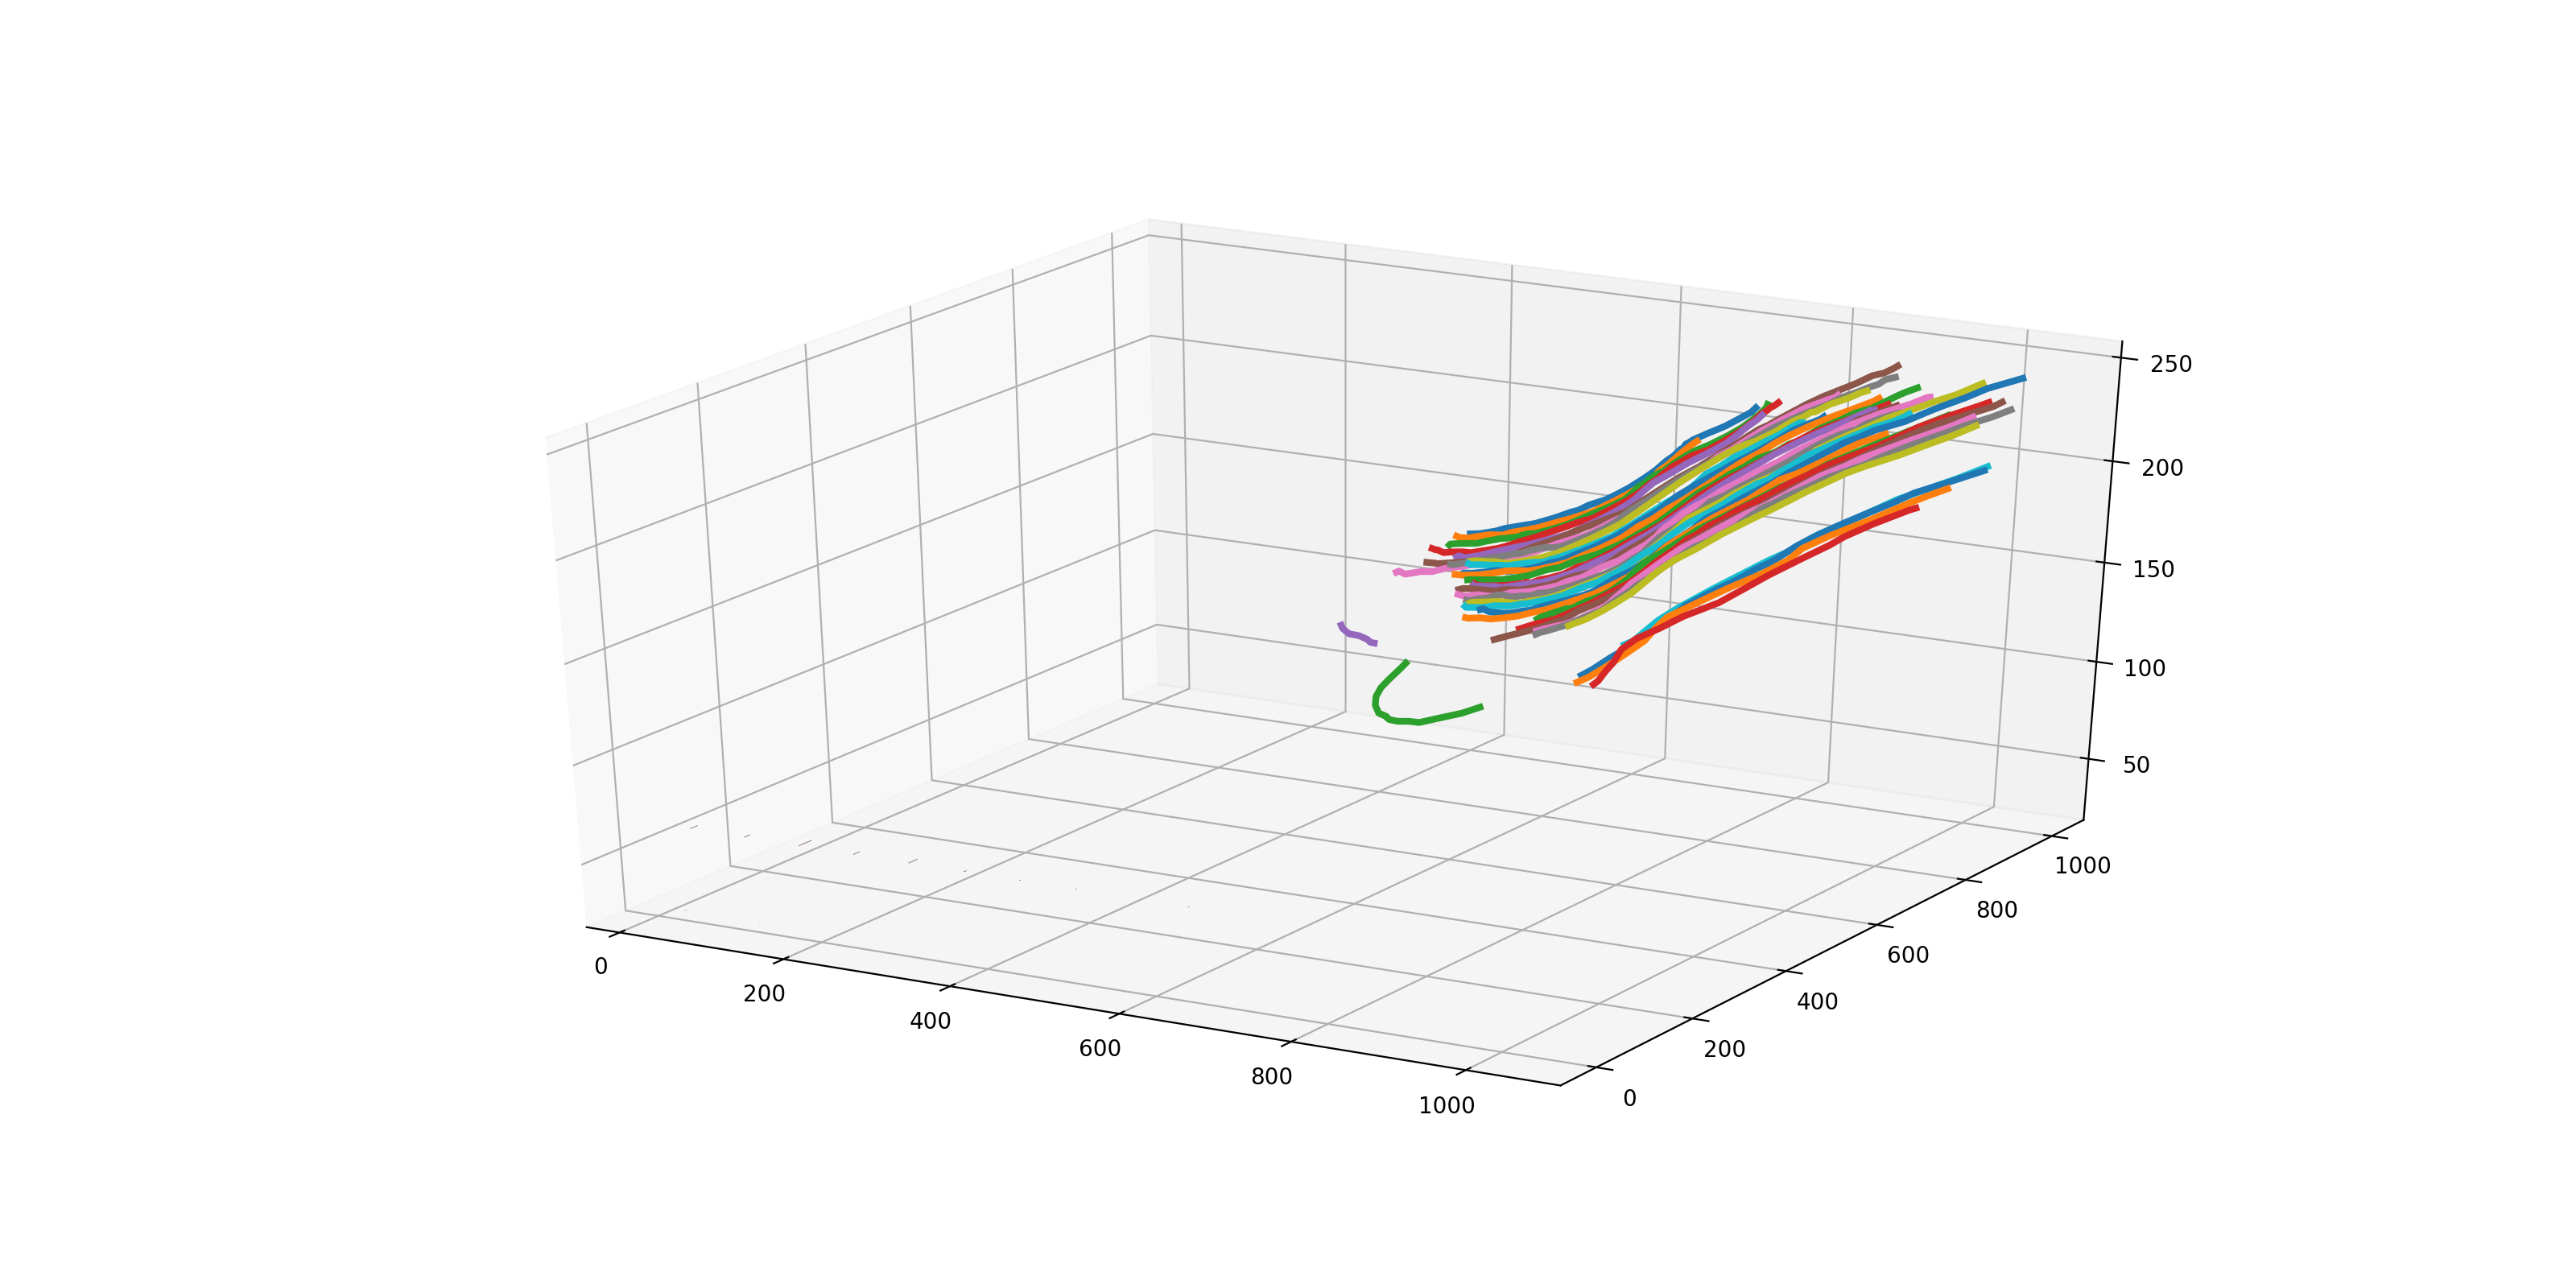

In [12]:
# plot membrane

# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[16,8])
ax=fig.add_subplot(111, projection='3d')

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3)

<IPython.core.display.Javascript object>


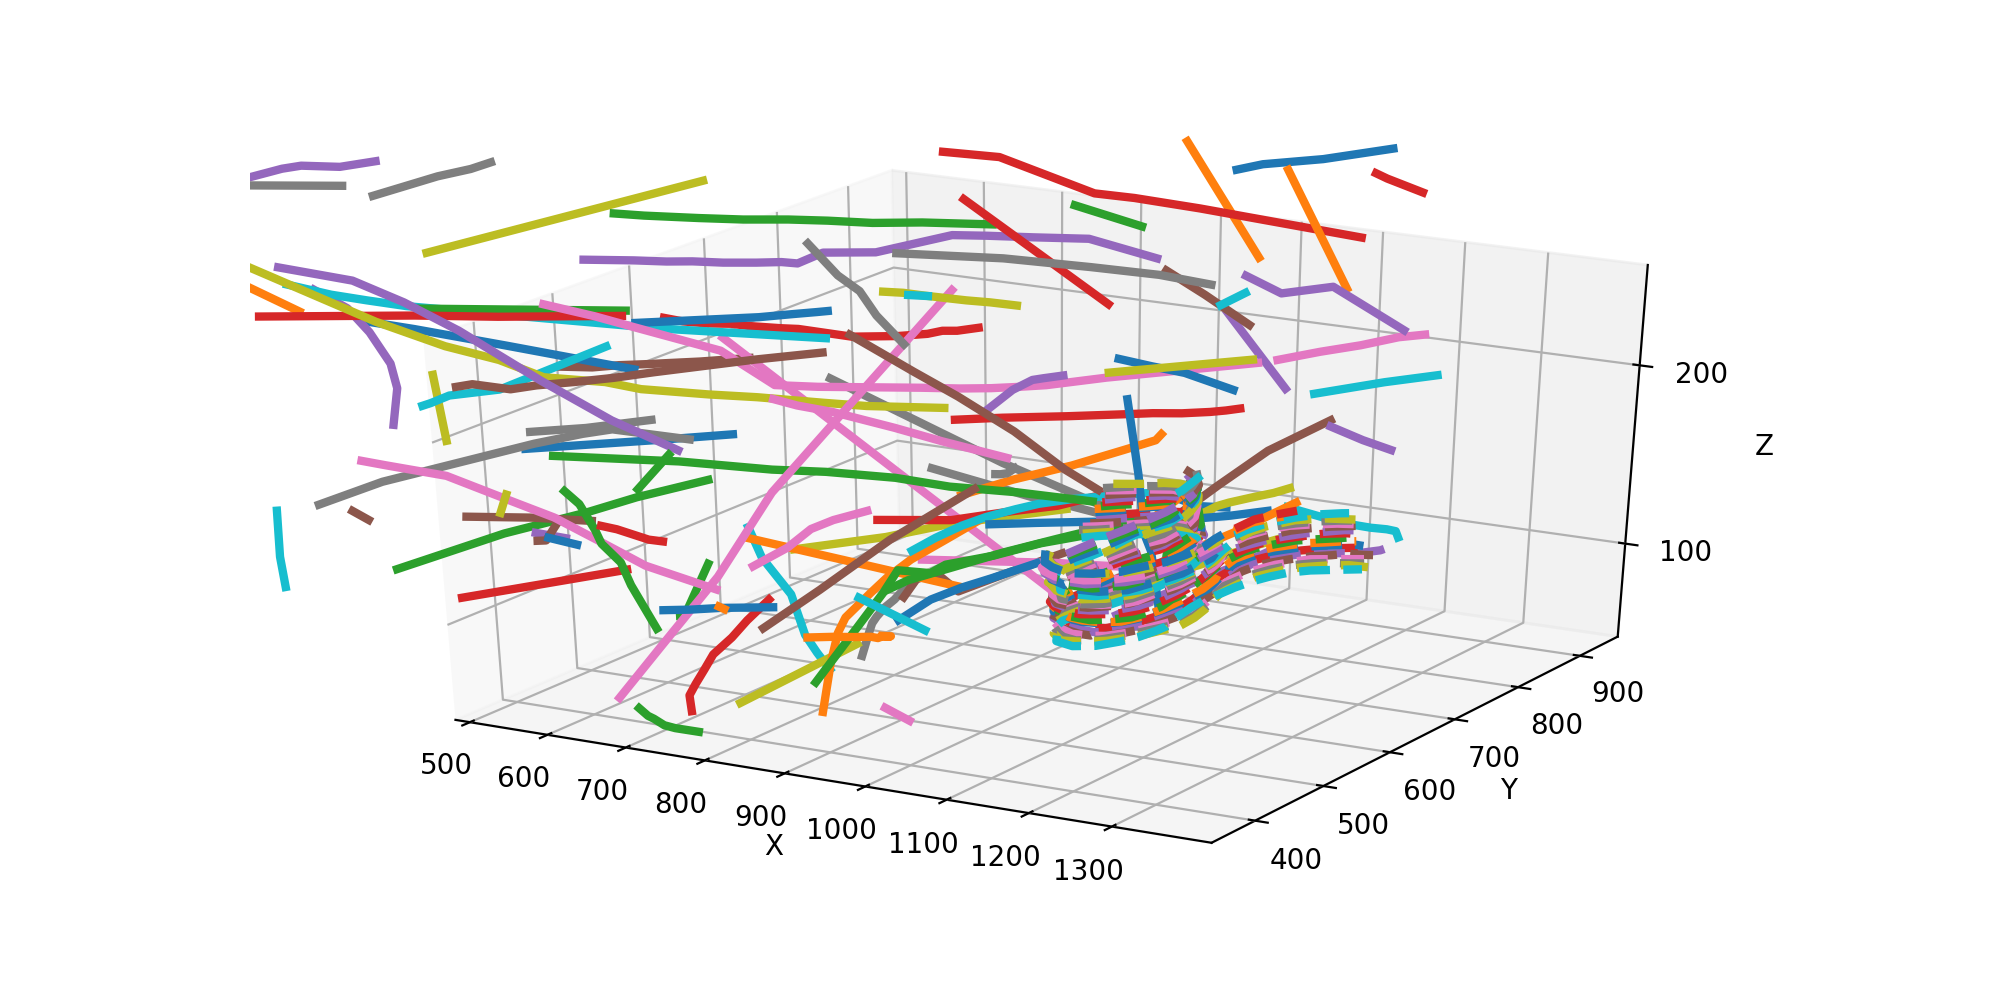

Text(0.5, 0, 'Z')

In [93]:
# plot actin and membrane
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
ax=fig.add_subplot(111, projection='3d')

# all_membranes = membrane.reset_index()
# CCP = all_membranes[all_membranes['object']==1]

for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

for filament in coords.index.unique():
    cur_filament = coords[coords.index==filament]
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3, linestyle='dashed')

    
# plot membrane
# pit = membranes[membranes['contour']==1]
# ax.plot(xs = pit['X'], ys=pit['Y'], zs = pit['Z'], linewidth=5)
# ax.autoscale(enable=True,tight=True) 

plt.xlim([500,1400])
plt.ylim([350,950])
ax.set_zlim([50,250])

ax.set_xticks(np.arange(500,1400,100))
ax.set_yticks(np.arange(400,1000,100))
ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# calculate directionality of filaments
## ydir is arcsin(y-y0)/length

In [17]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []
for filament in coords.index.unique():
    cur_filament = coords[coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))

#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    all_filaments.append(cur_filament)
    
all_filaments_df = pd.concat(all_filaments)
all_filaments_df

/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,X,Y,Z,ydir,zdir,length
fil,,,,,,
45,1131,719,259,-45.570713,12.894757,22.405357
45,1115,703,254,-45.570713,12.894757,22.405357
47,1164,562,117,39.592306,-29.015119,177.304822
47,1128,593,140,39.592306,-29.015119,177.304822
47,1117,598,146,39.592306,-29.015119,177.304822
47,1106,607,153,39.592306,-29.015119,177.304822
47,1077,634,172,39.592306,-29.015119,177.304822
47,1028,675,203,39.592306,-29.015119,177.304822
48,1113,623,155,75.608399,-12.430124,27.874720


In [21]:
#Directionality of Unbranched Filaments
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []
for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))

#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    all_filaments.append(cur_filament)
    
ub_all_filaments_df = pd.concat(all_filaments)
ub_all_filaments_df

/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,X,Y,Z,minus end point,ydir,zdir,length
fil,,,,,,,
87,1131,615,167,first,48.256561,11.840431,53.609701
87,1149,635,159,first,48.256561,11.840431,53.609701
87,1167,655,156,first,48.256561,11.840431,53.609701
97,917,552,149,first,39.578742,-2.988153,172.647039
97,984,611,151,first,39.578742,-2.988153,172.647039
...,...,...,...,...,...,...,...
512,1002,652,275,last,37.486459,5.821464,285.914323
512,1051,691,268,last,37.486459,5.821464,285.914323
512,1086,724,260,last,37.486459,5.821464,285.914323


In [22]:
# plot lengths sanity check
print(np.mean(filament_lengths))
plt.hist(filament_lengths)
# plt.show()

220.6008856597896


(array([14., 11., 24., 12., 17.,  5.,  2.,  2.,  0.,  2.]),
 array([ 14.38749457,  80.15142363, 145.91535269, 211.67928175,
        277.44321081, 343.20713988, 408.97106894, 474.734998  ,
        540.49892706, 606.26285612, 672.02678518]),
 <a list of 10 Patch objects>)

In [23]:
# plot distributions of angles

ydirs

[48.25656093686217,
 39.57874165026933,
 -38.24741998319791,
 -28.46090383984878,
 -30.90991867792928,
 28.187962063286992,
 88.89118787224037,
 68.50310097138328,
 -85.04436303413608,
 -87.06938002995973,
 62.12900597690514,
 -30.752857645301653,
 60.6700276857241,
 -46.10838452658991,
 -32.83058380596868,
 -87.94664864467765,
 46.14762574132114,
 36.85714333921197,
 47.007454609252896,
 36.206067221537154,
 -36.74591003108031,
 35.90821510134913,
 37.57466538603833,
 -56.306518030814054,
 -56.47402643987421,
 76.672231778474,
 62.64391682981277,
 54.382916622132306,
 51.80735927752379,
 39.721384542369265,
 57.29698097353847,
 36.513004074398474,
 -47.6776291686685,
 -44.858351670729746,
 35.78609919605706,
 51.081891738042614,
 -54.984075740134,
 88.04134357732794,
 46.762860796337336,
 15.560221896735056,
 53.8101640163877,
 6.69764830382463,
 -62.883809235395795,
 -73.8377956948961,
 55.255939767162495,
 54.07157057576006,
 -26.0536206919069,
 -43.30017112275542,
 -71.874953900247

In [24]:
# hsv 75% colormap
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
# %matplotlib inline
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('hsv')
new_cmap = truncate_colormap(cmap, 0, 0.75)

In [25]:
# choose a colormap

import matplotlib.colors as colors
import matplotlib.cm as cmx

# colorss = cm = plt.get_cmap('BrBG') 
colorss = cm = plt.get_cmap('seismic') 

# colorss = cm = plt.get_cmap(new_cmap)
 
# cNorm  = colors.Normalize(vmin=0, vmax=values[-1])

# set colorlim to [-1 to 1]

cNorm  = colors.Normalize(vmin=-90, vmax=90)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colorss)
print(scalarMap.get_clim())


(-90.0, 90.0)


<IPython.core.display.Javascript object>


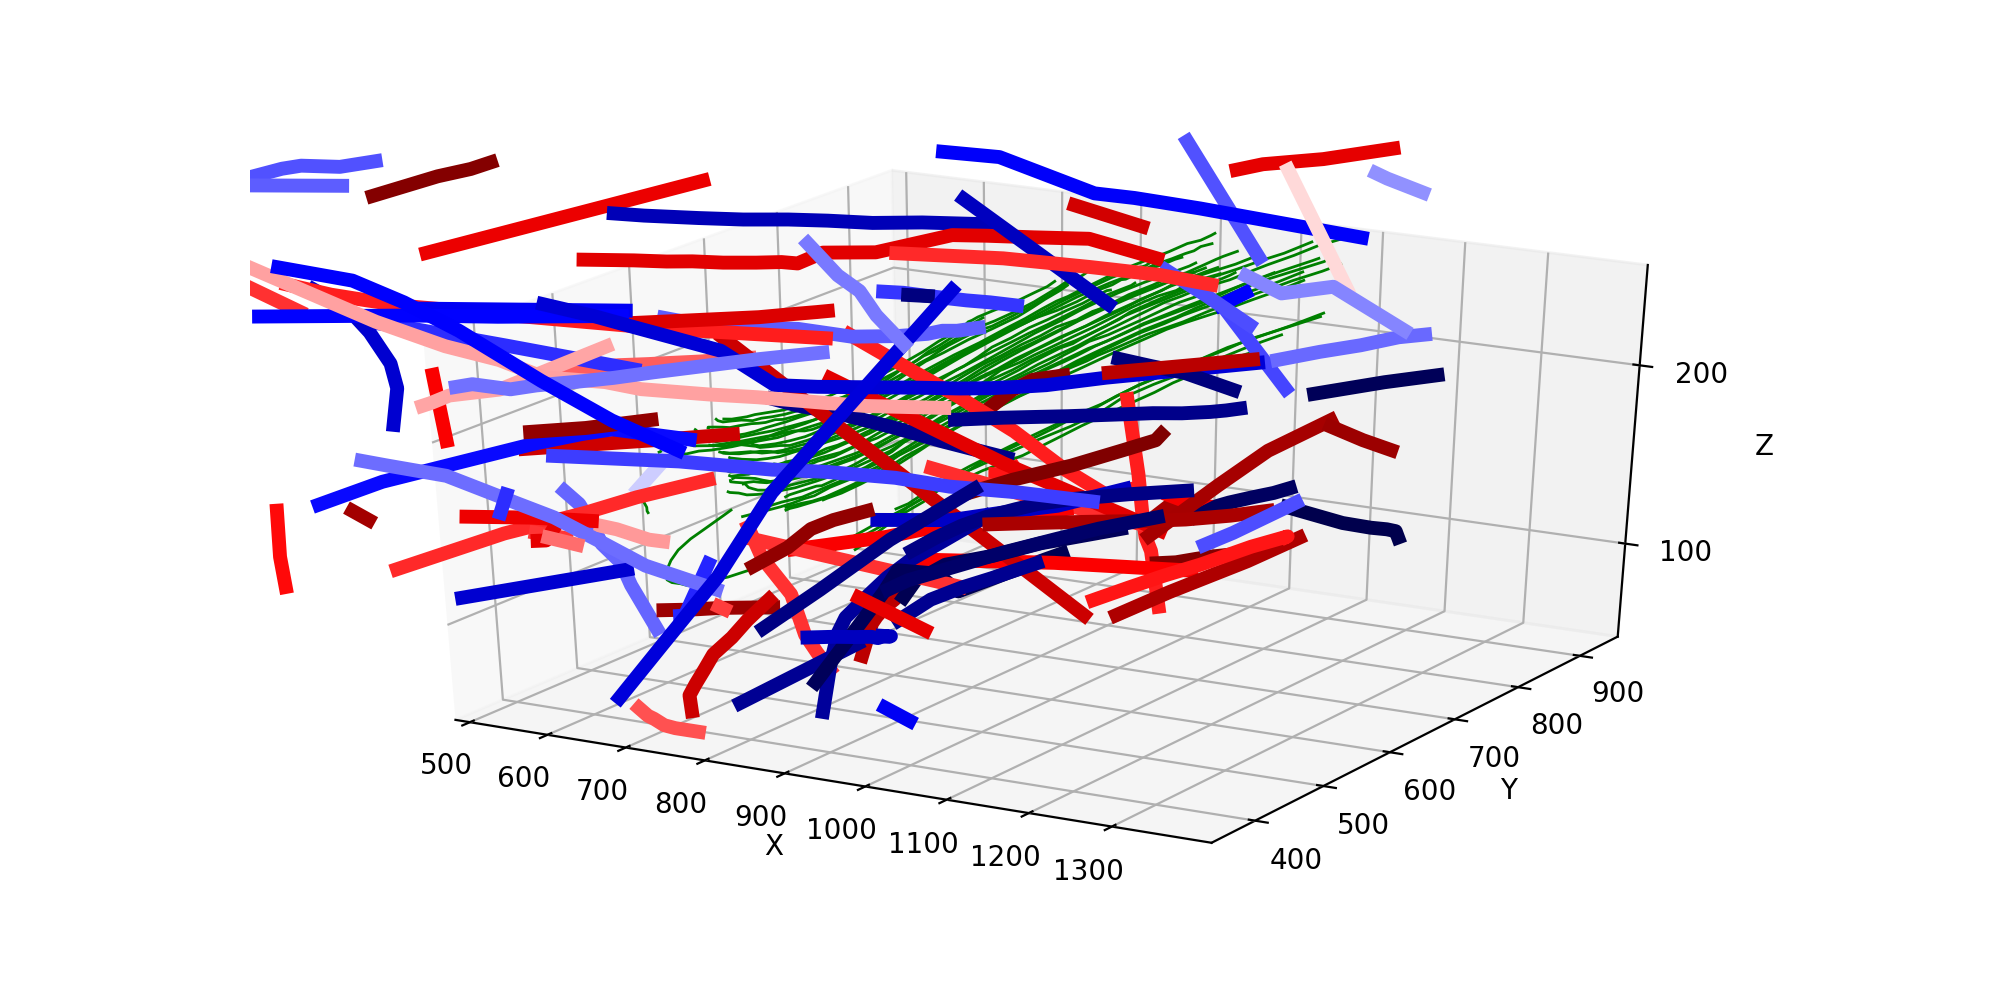

Text(0.5, 0, 'Z')

In [27]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
ax=fig.add_subplot(111, projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
for filament in ub_all_filaments_df.index.unique():
    cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
    
plt.xlim([500,1400])
plt.ylim([350,950])
ax.set_zlim([50,250])

ax.set_xticks(np.arange(500,1400,100))
ax.set_yticks(np.arange(400,1000,100))
ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [28]:
# save CCP membrane coordinates
CCP=CCP.reset_index().set_index(['object','contour'])

CCP.to_pickle('CCP_membrane_coordinates.pkl')
CCP

index    X    Y    Z
object contour                      
1      1            0  660  529  193
       1            1  672  527  194
       1            2  689  529  196
       1            3  700  528  198
       1            4  716  529  200
...               ...  ...  ...  ...
       34         931  881  890  164
       34         932  889  908  167
       34         933  909  931  172
       34         934  937  956  178
       34         935  943  960  179

[936 rows x 4 columns]

In [29]:
# import 3D meshing of membrane made by "symmetrecized plotting.ipynb"
import pickle as pkl
cur_mesh = pkl.load(open('rotate_obj.pkl','rb'))
cur_mesh

FileNotFoundError: [Errno 2] No such file or directory: 'rotate_obj.pkl'

<IPython.core.display.Javascript object>


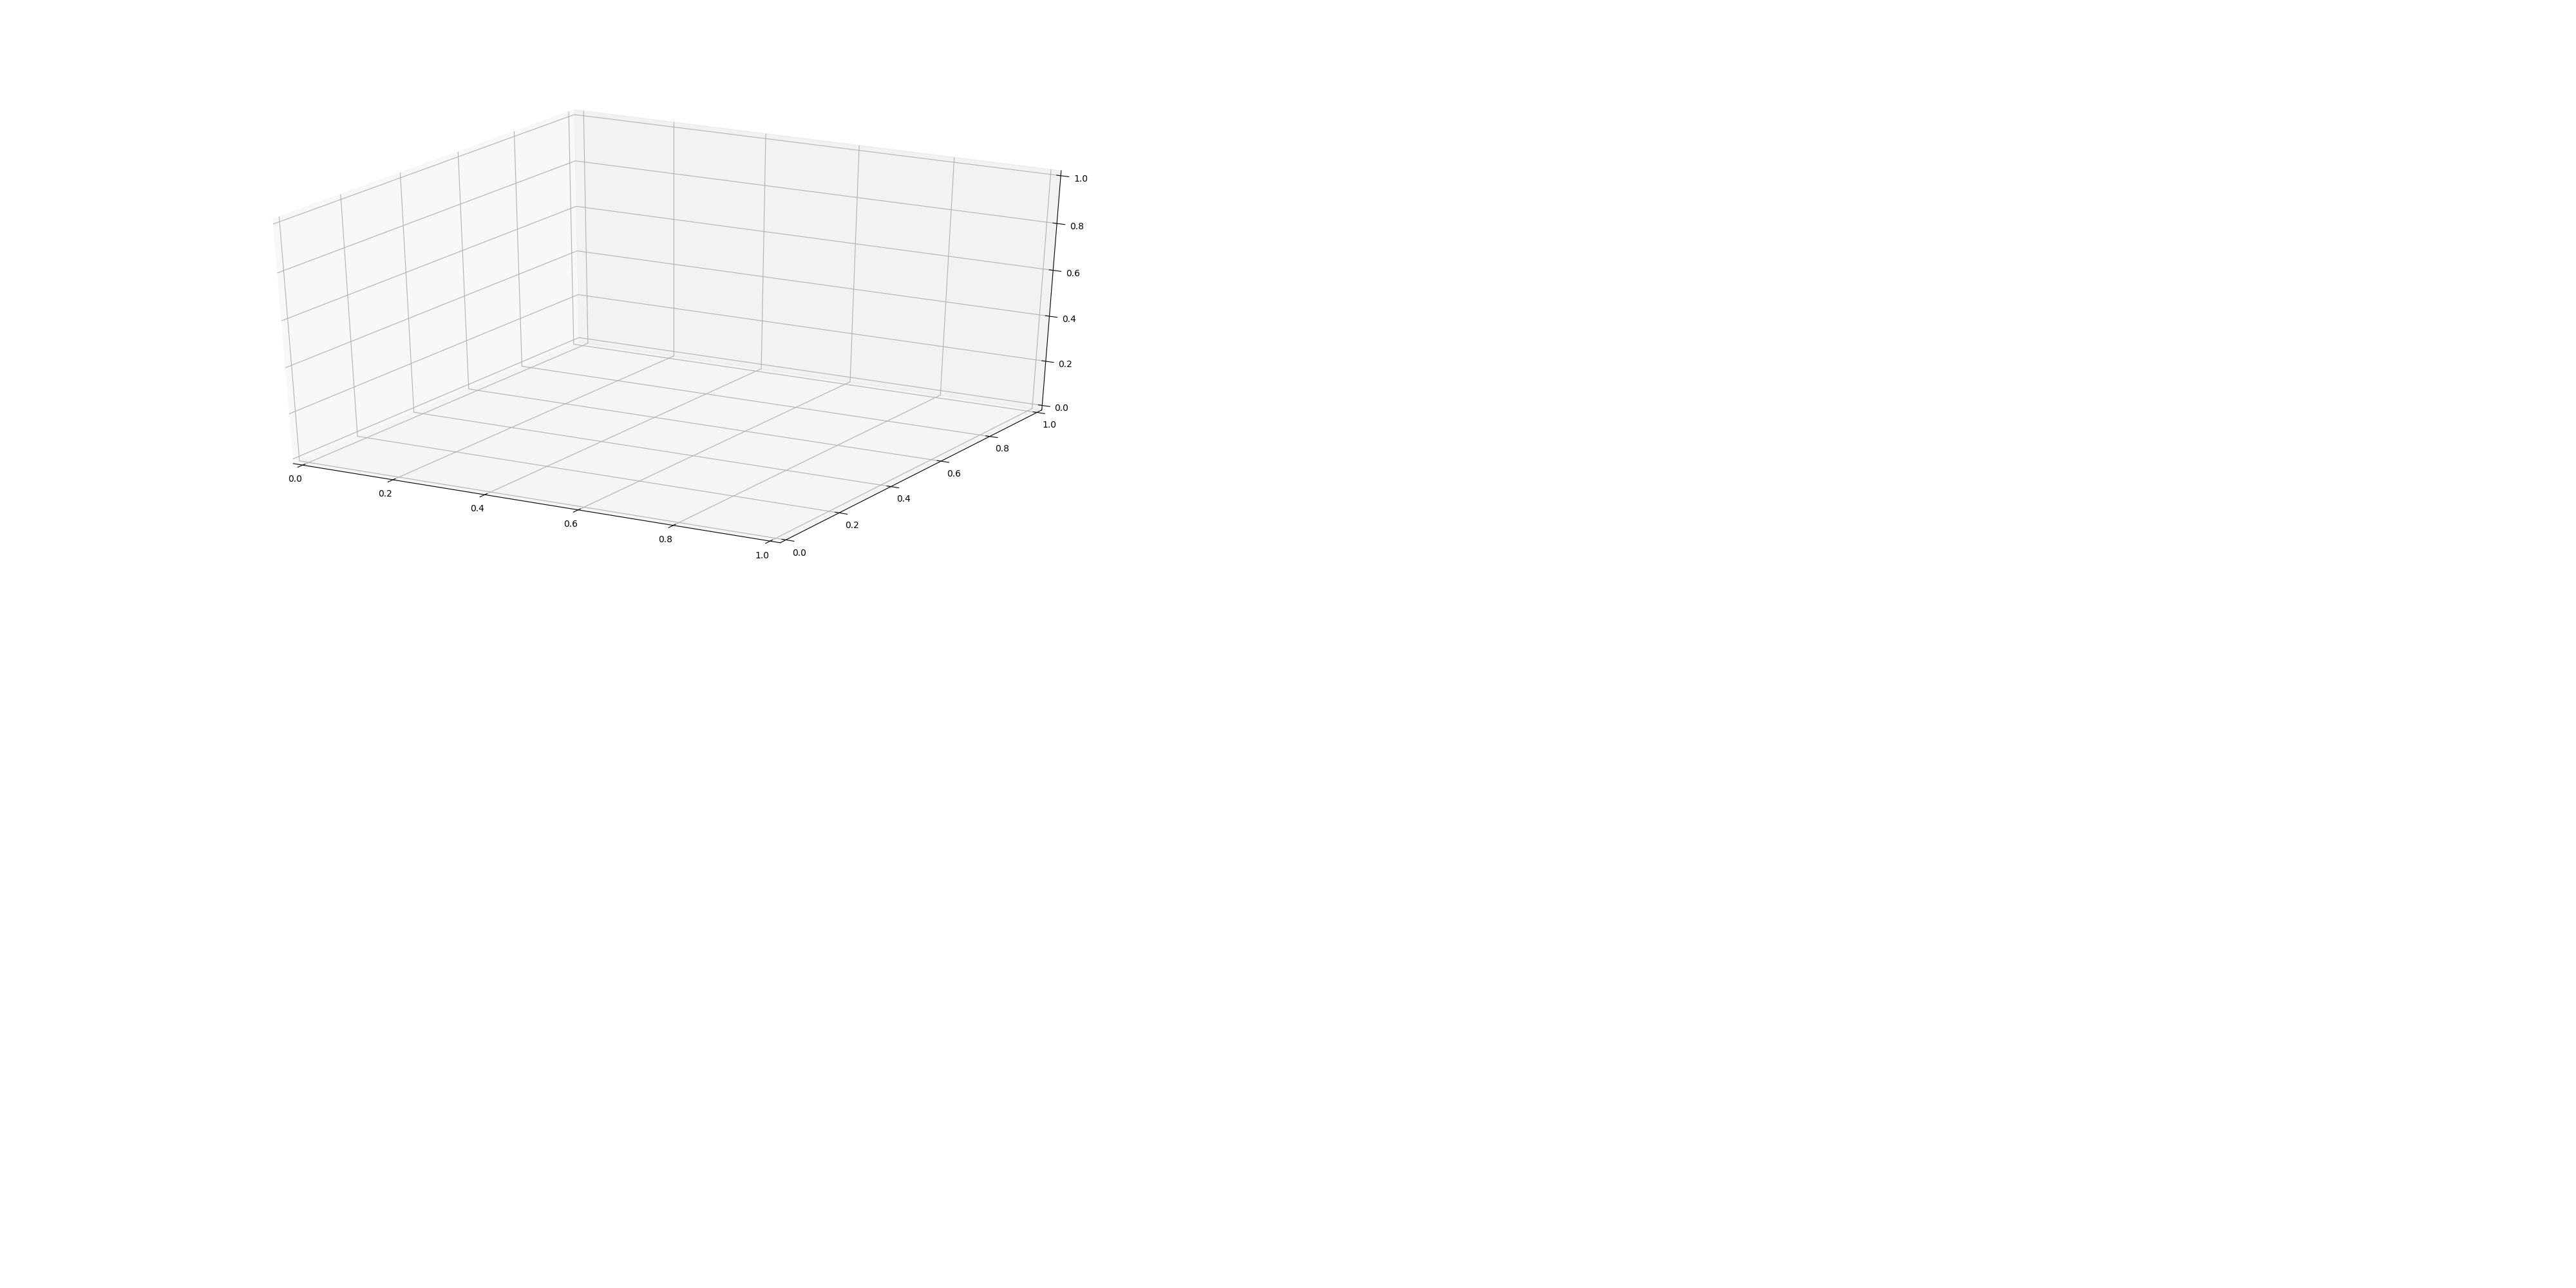

NameError: name 'cur_mesh' is not defined

In [30]:
# plot

fig = plt.figure(figsize=[20,10])
ax=fig.add_subplot(111, projection='3d')

# membrane
ax.plot_surface(cur_mesh.x3d,cur_mesh.y3d, cur_mesh.z3d, color='g', alpha=0.5)

# filaments

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# with actin

In [17]:
# # arrowheads??
# # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# import numpy as np
# from numpy import *
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)


In [37]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# a = Arrow3D(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], mutation_scale=20, 
#                 lw=3, arrowstyle="-|>", color="r")
# ax.add_artist(a)


## color code each segment